## Situational Pitching Behavior ##

# Imports and data Query #
For this project I will be using data from the entirety of the 2017 regular season. This query takes a very long time to run and should only be run if the user does not have access to final_pitching_data.csv

In [3]:
from pybaseball import statcast
import pandas as pd
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup

In [226]:
# query - very large, only run if no exisiting data csv
data = statcast(start_dt='2017-04-01', end_dt='2017-10-01')

This is a large query, it may take a moment to complete


KeyboardInterrupt: 

Read from the csv into a dataframe

In [4]:
# read query data to a csv is necessary, otherwise grab from csv
# data.to_csv("final_pitching_data.csv")
data = pd.read_csv("final_pitching_data.csv") 

C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Core Functions #
    - lookup: responsible for pulling the specific pitching data from the dataframe
    - isolate_data: statstical preprocessing of the lookup data
    - process_data: shape the data into structures that can be easily displayed
    - display_results: generate plots and print statements of processed data
    - driver: driver function for submitting a specific situation query

In [25]:
def lookup(playerID, on_1b, on_2b, on_3b):
    # runner on first
    if on_1b and not on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].notnull()) & (data['on_2b'].isnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on second
    elif not on_1b and on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].isnull()) & (data['on_2b'].notnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on third
    elif not on_1b and not on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].isnull()) & (data['on_2b'].isnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
   
    # runner on first and second
    elif on_1b and on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].notnull()) & (data['on_2b'].notnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on first and third 
    elif on_1b and not on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].notnull()) & (data['on_2b'].isnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on second and third
    elif not on_1b and on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].isnull()) & (data['on_2b'].notnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on first, second, third
    elif on_1b and  on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].notnull()) & (data['on_2b'].notnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    # no runners on
    elif not on_1b and not on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['on_1b'].isnull()) & (data['on_2b'].isnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    return situation_data

In [26]:
def isolate_data(sit_data):
    # compare the types of pitches pitchers throw at home vs away
    pitches = {}
    descriptions = {}
    pitch_type_counts = sit_data.groupby(['pitch_type']).count().reset_index()    
    total_pitches = pitch_type_counts['pitcher'].sum()

    #add the pitch types and their frequency to a dictionary 
    for index, row in pitch_type_counts.iterrows():
        pitches[row['pitch_type']] = row['pitcher']
        
    # get mean location data
    x_location_mean = sit_data['plate_x'].mean()
    z_location_mean = sit_data['plate_z'].mean()
 
    # get number of strikes/balls/hits thrown in situation
    pitch_description_counts = sit_data.groupby(['type']).count().reset_index()
    for index, row in pitch_description_counts.iterrows():
        descriptions[row['type']] = row['pitcher']
    
    return total_pitches, pitches, descriptions, x_location_mean, z_location_mean

In [27]:
def process_data(isol_data):
    # if there is data for this situation, isolate the data points we are looking for
    tot_pitches, pitch_counts, pitch_descriptions, x_loc_mean, z_loc_mean = isolate_data(isol_data)
    # get the most likely pitch to be thrown
    max_pitch = 0
    # dictonary to store the types of pitches they could throw and the statistical frequency that they will
    pitch_freqs = {}
    for key, value in pitch_counts.items():
        pitch_freqs[key] = value/tot_pitches

    # dictionary to store outcome percentages
    outcome_freqs = {}
    for key, value in pitch_descriptions.items():
        outcome_freqs[key] = value/tot_pitches

    return tot_pitches, pitch_freqs, outcome_freqs, x_loc_mean, z_loc_mean
       

In [28]:
def display_results(p_data):
    print("There are", p_data[0], "data points for this pitcher in this situation")
    
    print("The odds that the pitcher will throw a specific pitch in this situation are the following \n", p_data[1])
    plt.bar(range(len(p_data[1])), list(p_data[1].values()), align='center')
    plt.xticks(range(len(p_data[1])), list(p_data[1].keys()))
    plt.title("Pitch Frequencies")
    plt.xlabel("Pitch Type")
    plt.ylabel("Frequency")
    plt.show()
    
    print("The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following \n", p_data[2])
    plt.bar(range(len(p_data[2])), list(p_data[2].values()), align='center')
    plt.xticks(range(len(p_data[2])), list(p_data[2].keys()))
    plt.title("Outcome Frequencies")
    plt.xlabel("Result of Pitch")
    plt.ylabel("Frequency")
    plt.show()
    
    # get the average location of where the pitch will be thrown based off the mean x (horizontal) location and mean z (vertical) location
    print("The average position of the ball over the plate, from the catcher's perspective,\n (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) \n in this situation for this pitcher is \n(", p_data[3], ",", p_data[4],")")
    plt.plot(p_data[3], p_data[4], 'ro', markersize=15)
    plt.grid(color='black', linestyle='-', linewidth=.8)
    plt.axis([-5, 5, -5, 5])
    plt.xlabel("Horiztional Position")
    plt.ylabel("Vertical Position")
    plt.title("Average Pitch Location")
    plt.show()

In [29]:
def driver(first, last, on_1b, on_2b, on_3b):
    playerID = playerid_lookup(last, first)
    pid = playerID.iloc[0]['key_mlbam']
    # call the lookup function with the specified siutational parameters
    SPB_data = lookup(pid, on_1b, on_2b, on_3b)
    # if the length of the returned data frame is 0 there is no data for that specific situation
    if (len(SPB_data) == 0):
        print("No data available for described situation")
        return
    
    # process the isolated data
    processed_data = process_data(SPB_data)

    # display results
    display_results(processed_data)

## Demonstration ##
Below is a demonstartion of how this application can be used. I will provide examples that show how pitchers change their behavior as situations change, but this application can be applied to any pitcher, not just the ones in my demonstration.

## Kyle Freeland ##

Gathering player lookup table. This may take a moment.
There are 1423 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.08503162333099086, 'CU': 0.04778636683063949, 'FF': 0.2494729444834856, 'FT': 0.3752635277582572, 'SL': 0.24244553759662685}


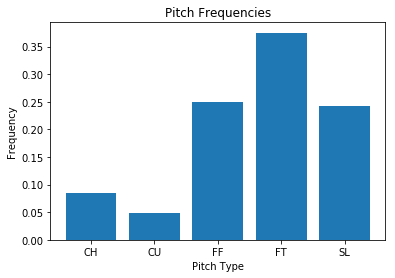

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.3836964160224877, 'S': 0.4342937456078707, 'X': 0.19465917076598735}


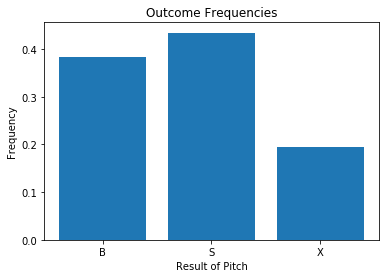

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( 0.15622775825720284 , 2.352009135628952 )


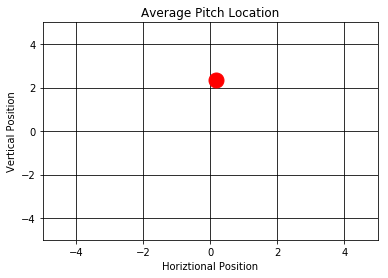

In [30]:
# first name, last name, on_1b, on_2b, on_3b
driver("kyle", "freeland", False, False, False)

Gathering player lookup table. This may take a moment.
There are 190 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.03684210526315789, 'CU': 0.031578947368421054, 'FF': 0.28421052631578947, 'FT': 0.39473684210526316, 'SL': 0.25263157894736843}


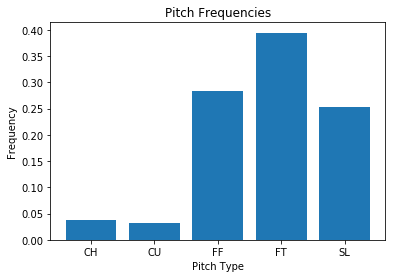

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.3684210526315789, 'S': 0.4473684210526316, 'X': 0.18421052631578946}


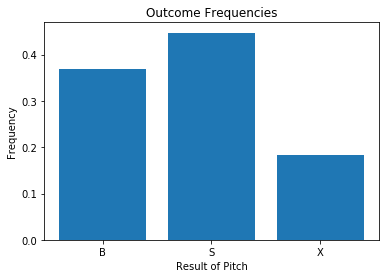

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( 0.020551052631578956 , 2.4461526315789466 )


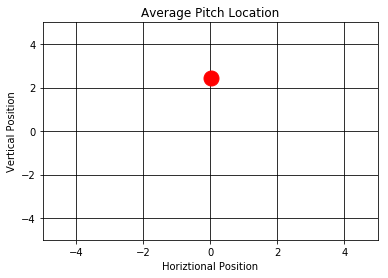

In [31]:
# first name, last name, on_1b, on_2b, on_3b
driver("kyle", "freeland", True, True, False)

Gathering player lookup table. This may take a moment.
There are 53 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.07547169811320754, 'FF': 0.33962264150943394, 'FT': 0.39622641509433965, 'SL': 0.18867924528301888}


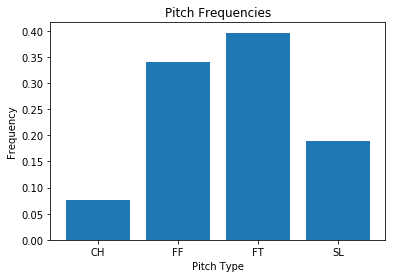

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.39622641509433965, 'S': 0.33962264150943394, 'X': 0.2641509433962264}


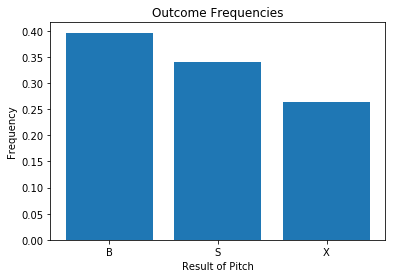

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( 0.13173584905660377 , 2.3209792452830187 )


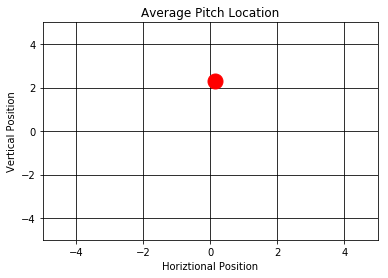

In [33]:
# first name, last name, on_1b, on_2b, on_3b
driver("kyle", "freeland", True, True, True)

## Statistical Comparison ##
SPB is very difficult to compare to traditional statistics. I will be taking mlb.com's list of most clutch pitchers of all time (https://www.mlb.com/news/best-clutch-pitchers-in-mlb-history-c298312438) and seeing how those pitchers have historically performed in high intensity situations from the SPB perspective. 

## Justin Verlander ##
Verlander is credited with a very low career ERA and is said to be a very clutch pitcher. I will be using SPB to show how Verrlander has performed in three different high pressure situations

#### Bases Loaded ####

Gathering player lookup table. This may take a moment.
There are 61 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.01639344262295082, 'CU': 0.19672131147540983, 'FF': 0.5245901639344263, 'SL': 0.26229508196721313}


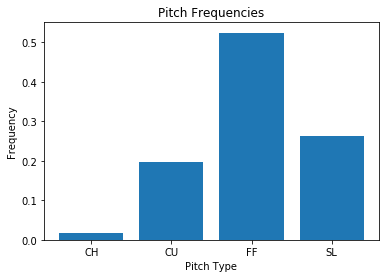

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.26229508196721313, 'S': 0.5737704918032787, 'X': 0.16393442622950818}


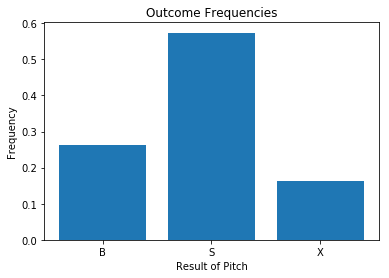

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( 0.3017901639344262 , 2.517219672131147 )


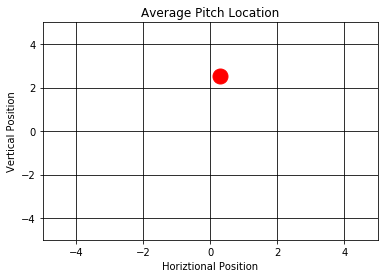

In [34]:
# first name, last name, on_1b, on_2b, on_3b
# bases loaded
driver("justin", "verlander", True, True, True)

#### Runner on third ####

Gathering player lookup table. This may take a moment.
There are 11 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'FF': 0.6363636363636364, 'SL': 0.36363636363636365}


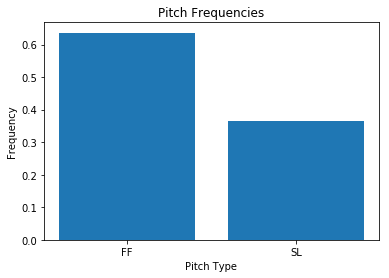

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.36363636363636365, 'S': 0.45454545454545453, 'X': 0.18181818181818182}


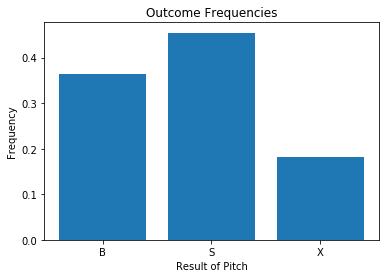

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( 0.5196363636363636 , 2.9803272727272727 )


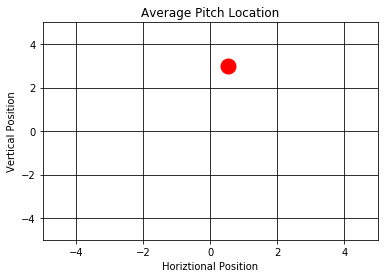

In [37]:
# first name, last name, strikes, balls, on_1b, on_2b, on_3b
# runners on second and third 
driver("justin", "verlander", False, True, True)

#### Runners on first and second ####

Gathering player lookup table. This may take a moment.
There are 159 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.012578616352201259, 'CU': 0.23270440251572327, 'FF': 0.6037735849056604, 'SL': 0.1509433962264151}


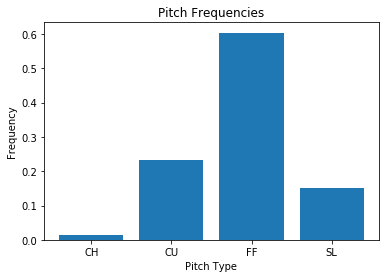

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.32075471698113206, 'S': 0.4968553459119497, 'X': 0.18238993710691823}


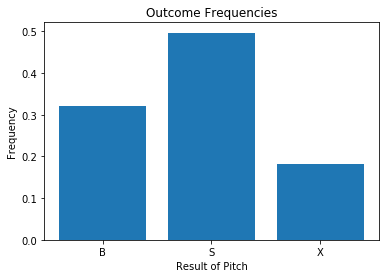

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( 0.3732484276729558 , 2.418383647798742 )


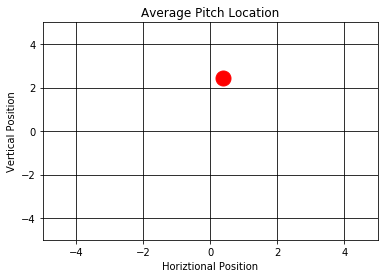

In [36]:
# first name, last name, on_1b, on_2b, on_3b
# runner on first and second 
driver("justin", "verlander", True, True, False)

## Analysis ##

From an intuitive perspective, the three situations above all help support the case of Justin Verlander being a "clutch" player. When the bases are loaded he throws strikes 57% of the time. When there are runners on Second and Third he throws strikes 45% of the time. When there are runners on first and second he throws strikes 49% of the time. The data also shows that in these high pressure situations Verlander strongly favors throwing four seem fastballs (FF). This data can be useful for batters who have to face Verlander in these high pressure situations. Verlander also has a very low hit in to play percentage in all three situations. Tyically in these high pressure situations verlander throws the pitch straight over the center of the plate.

## Jake Arrieta ##

#### Bases Loaded ####

Gathering player lookup table. This may take a moment.
There are 36 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.16666666666666666, 'CU': 0.1111111111111111, 'SI': 0.5277777777777778, 'SL': 0.19444444444444445}


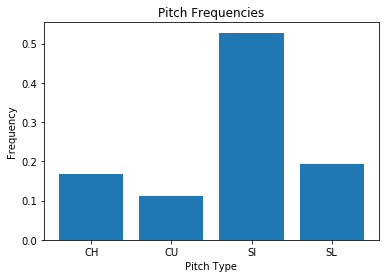

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.3333333333333333, 'S': 0.4722222222222222, 'X': 0.19444444444444445}


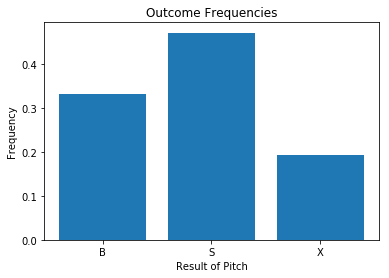

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( -0.12509722222222222 , 2.084352777777778 )


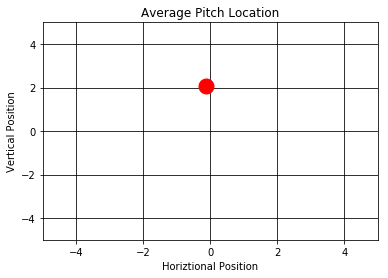

In [38]:
# first name, last name, on_1b, on_2b, on_3b
# bases loaded
driver("jake", "arrieta", True, True, True)

#### Runners on Second and Third ####

Gathering player lookup table. This may take a moment.
There are 63 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.12698412698412698, 'CU': 0.20634920634920634, 'SI': 0.36507936507936506, 'SL': 0.30158730158730157}


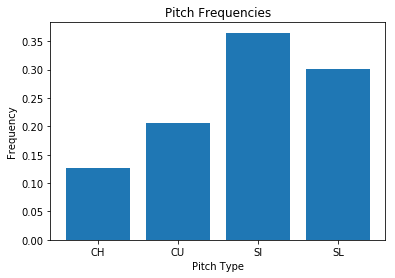

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.3333333333333333, 'S': 0.4444444444444444, 'X': 0.2222222222222222}


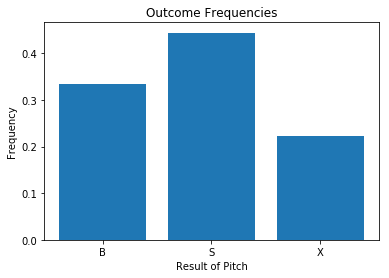

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( -0.041556451612903195 , 2.199925806451613 )


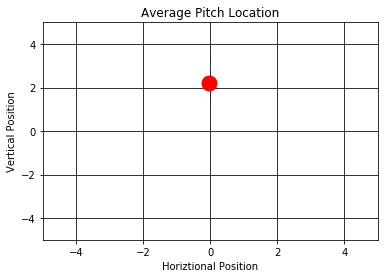

In [39]:
# first name, last name, on_1b, on_2b, on_3b
# bases loaded
driver("jake", "arrieta", False, True, True)

#### Runners on First and Second ####

Gathering player lookup table. This may take a moment.
There are 151 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'CH': 0.052980132450331126, 'CU': 0.2052980132450331, 'FF': 0.026490066225165563, 'SI': 0.5165562913907285, 'SL': 0.1986754966887417}


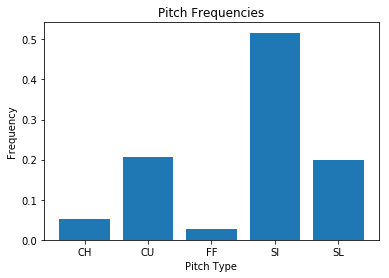

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.423841059602649, 'S': 0.423841059602649, 'X': 0.152317880794702}


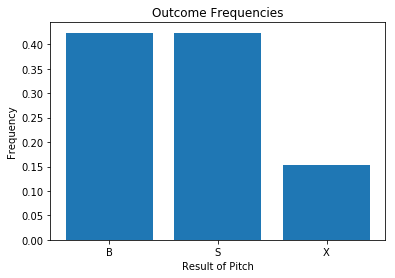

The average position of the ball over the plate, from the catcher's perspective,
 (0 in the x direction will be directly over the center of the plate horizontally, numbers in the y direction are an indication of how high the ball will be above the plate) 
 in this situation for this pitcher is 
( -0.03705761589403973 , 2.2320066225165562 )


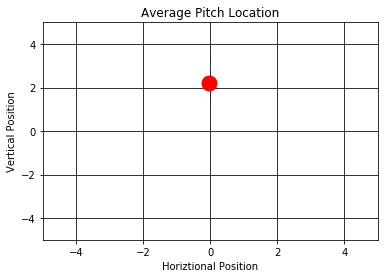

In [40]:
# first name, last name, on_1b, on_2b, on_3b
# bases loaded
driver("jake", "arrieta", True, True, False)

## Analysis ##
We can see that Jake Arrieta has a lower strike percentage than Verlander and also a heavy preference towards throwing sliders in these high pressure situations. This is very useful information for batters who have to face Arrieta, in fact Arrieta throws almost no four seem fast balls in these situations. The one similarity that Arrieta has to Verlander is there tendancy to throw directly over the plate in these situations. 